In [1]:
!pip install -U efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.4 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import keras
import keras.layers as L
import efficientnet.keras as efn

model = tf.keras.Sequential([L.InputLayer(input_shape=(80,80,3)),L.Conv2D(3,3,activation='relu',padding='same'),efn.EfficientNetB0(include_top=False,input_shape=(),weights='imagenet'),
        L.GlobalAveragePooling2D(),
        L.Dense(32,activation='relu'),
        L.Dense(1, activation='sigmoid')])

model.summary()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss='binary_crossentropy', metrics=[keras.metrics.AUC()])

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

16804768/16804768 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 3)         84        
                                                                 
 efficientnet-b0 (Functional  (None, None, None, 1280)  4049564  
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 32)                40992     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                         

In [3]:
!python -m pip install gwpy
!pip install astropy==4.2.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ligo-segments: filename=ligo_segments-1.4.0-cp310-cp310-linux_x86_64.whl size=51670 sha256=1281cda1a37e38b637629774246ceefdce32272937e395345032c9a8920064e9
  Stored in directory: /root/.cache/pip/wheels/6d/48/d1/3466977be4e41ba57f92ad0d5619f083df43cf319a151c4e06
Successfully built ligo-segments
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 3.1 MB/s eta 0:00:0000:0100:01m
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [27 lines of output]
      Traceback (most recent call last):
        File "/opt/conda/

In [4]:
from gwpy.timeseries import TimeSeries
from gwpy.plot import Plot
import numpy as np
from scipy import signal
from sklearn.preprocessing import MinMaxScaler
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd

In [5]:
train_labels = pd.read_csv("/kaggle/input/g2net-gravitational-wave-detection/training_labels.csv")
sample_submission = pd.read_csv("/kaggle/input/g2net-gravitational-wave-detection/sample_submission.csv")

(80, 80, 3)


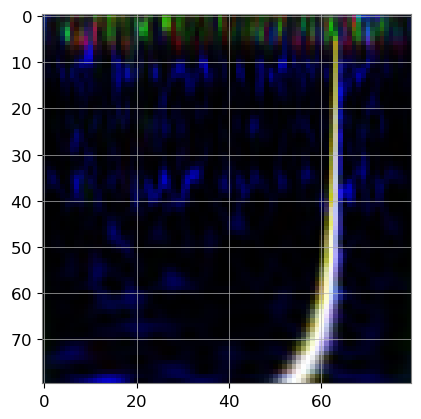

In [6]:
Q_RANGE = (16,32)
F_RANGE = (30,400)

def id2path(idx,is_train=True):
    path = '../input/g2net-gravitational-wave-detection'
    if is_train:
        path += '/train/'+idx[0]+'/'+idx[1]+'/'+idx[2]+'/'+idx+'.npy'
    else:
        path += '/test/'+idx[0]+'/'+idx[1]+'/'+idx[2]+'/'+idx+'.npy'
    return path

def read_file(fname, is_train):
    data = np.load(id2path(fname, is_train))
    d1 = TimeSeries(data[0,:], sample_rate=2048)
    d2 = TimeSeries(data[1,:], sample_rate=2048)
    d3 = TimeSeries(data[2,:], sample_rate=2048)
    return d1, d2, d3


def preprocess(d1, d2, d3, bandpass=False, lf=35, hf=350):
    white_d1 = d1.whiten(window=("tukey",0.2))
    white_d2 = d2.whiten(window=("tukey",0.2))
    white_d3 = d3.whiten(window=("tukey",0.2))
    if bandpass: # bandpass filter
        bp_d1 = white_d1.bandpass(lf, hf) 
        bp_d2 = white_d2.bandpass(lf, hf)
        bp_d3 = white_d3.bandpass(lf, hf)
        return bp_d1, bp_d2, bp_d3
    else: # only whiten
        return white_d1, white_d2, white_d3

def create_rgb(fname, is_train):
    r1, r2, r3 = read_file(fname, is_train)
    p1, p2, p3 = preprocess(r1, r2, r3)
    hq1 = p1.q_transform(qrange=Q_RANGE, frange=F_RANGE, logf=True, whiten=False)
    hq2 = p2.q_transform(qrange=Q_RANGE, frange=F_RANGE, logf=True, whiten=False)
    hq3 = p3.q_transform(qrange=Q_RANGE, frange=F_RANGE, logf=True, whiten=False)
    img = np.zeros([hq1.shape[0], hq1.shape[1], 3], dtype=np.uint8)
    scaler = MinMaxScaler()
    img[:,:,0] = 255*scaler.fit_transform(hq1)
    img[:,:,1] = 255*scaler.fit_transform(hq2)
    img[:,:,2] = 255*scaler.fit_transform(hq3)
    img_pil = Image.fromarray(img).rotate(90, expand=1).resize((80,80))
    return np.array(img_pil)

# Ejemplo de uso:
image = create_rgb(sample_submission["id"][109], is_train = False)
print(image.shape)
plt.imshow(image)



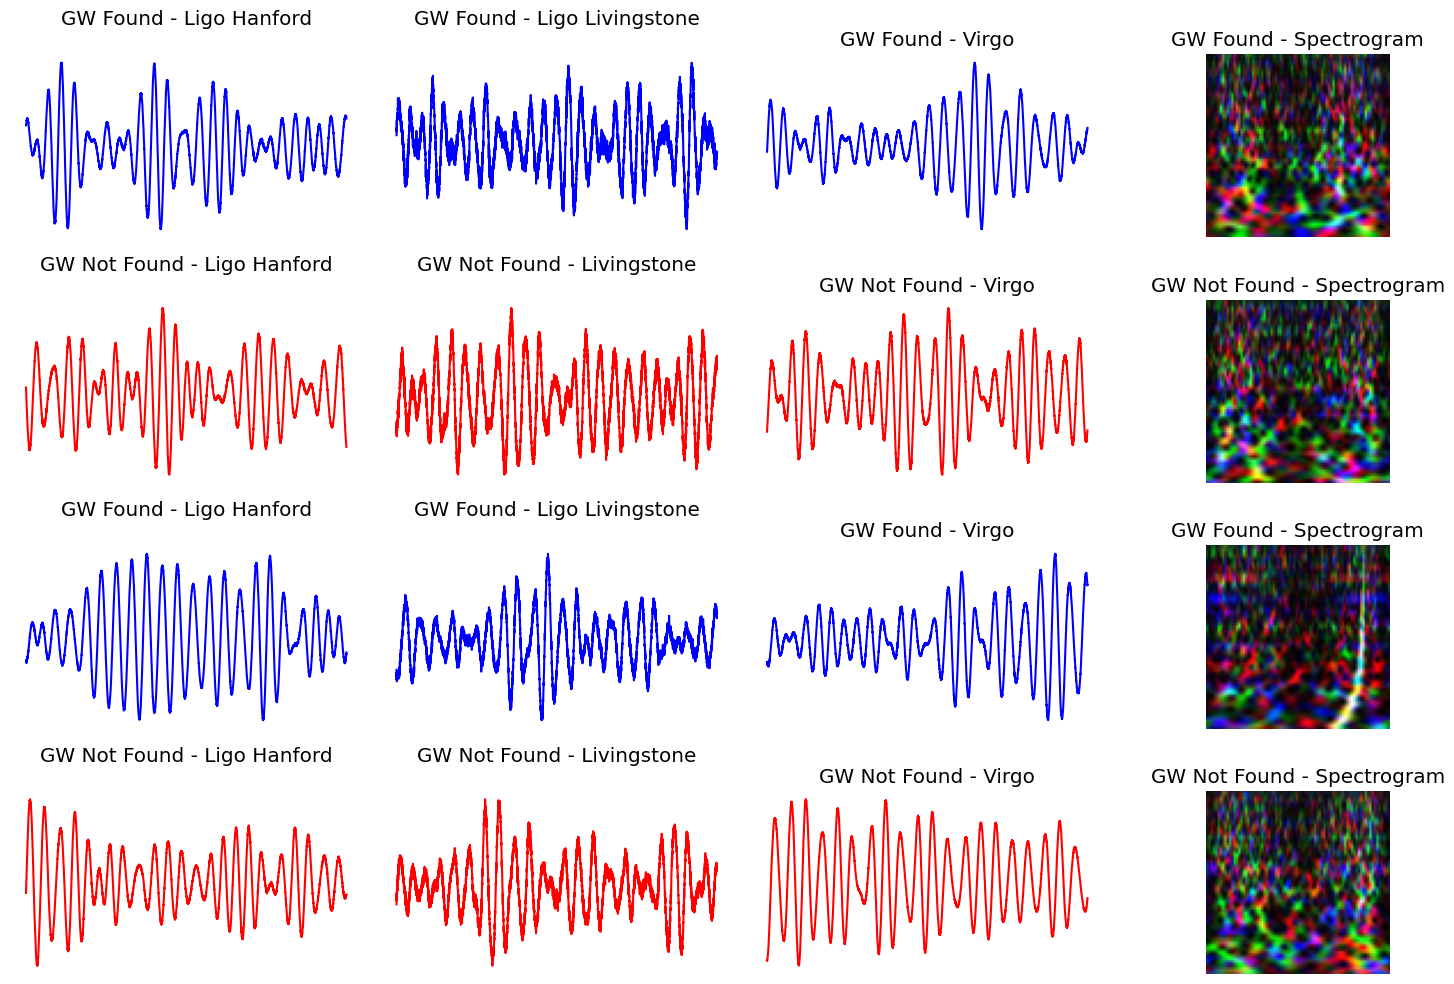

In [7]:
data_sample_target = train_labels[train_labels["target"] == 1].reset_index(drop = True)
targets = data_sample_target["id"].iloc[48:50]
no_targets = train_labels[train_labels["target"] == 1]["id"].head(2)
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(4, 4, figure=fig)

for i, (target, no_target) in enumerate(zip(targets, no_targets)):
    # Subplot para GW Found (gráfico de líneas)
    ax1 = fig.add_subplot(gs[i*2, 0])
    ax1.plot(np.load(id2path(target))[1, :], color='blue')
    ax1.set_title("GW Found - Ligo Hanford")
    ax1.set_axis_off()

    ax2 = fig.add_subplot(gs[i*2, 1])
    ax2.plot(np.load(id2path(target))[2, :], color='blue')
    ax2.set_title("GW Found - Ligo Livingstone")
    ax2.set_axis_off()

    ax3 = fig.add_subplot(gs[i*2, 2])
    ax3.plot(np.load(id2path(target))[0, :], color='blue')
    ax3.set_title("GW Found - Virgo")
    ax3.set_axis_off()
    
    ax4 = fig.add_subplot(gs[i*2, 3])
    ax4.imshow(create_rgb(target, is_train = True))
    ax4.set_title("GW Found - Spectrogram")
    ax4.set_axis_off()
    

    # Subplot para GW Not Found (gráfico de líneas)
    ax5 = fig.add_subplot(gs[i*2 + 1, 0])
    ax5.plot(np.load(id2path(no_target))[1, :], color='red')
    ax5.set_title("GW Not Found - Ligo Hanford")
    ax5.set_axis_off()

    ax6 = fig.add_subplot(gs[i*2 + 1, 1])
    ax6.plot(np.load(id2path(no_target))[2, :], color='red')
    ax6.set_title("GW Not Found - Livingstone")
    ax6.set_axis_off()

    ax7 = fig.add_subplot(gs[i*2 + 1, 2])
    ax7.plot(np.load(id2path(no_target))[0, :], color='red')
    ax7.set_title("GW Not Found - Virgo")
    ax7.set_axis_off()

    ax8 = fig.add_subplot(gs[i*2 + 1, 3])
    ax8.imshow(create_rgb(no_target, is_train = True))
    ax8.set_title("GW Not Found - Spectrogram")
    ax8.set_axis_off()

plt.tight_layout()
plt.show()

In [8]:
import math
class G2NetDataset(tf.keras.utils.Sequence):
    def __init__(self, data, y = None, batch_size = 512, shuffle = True):
        
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        if y is not None:
            self.is_train = True
        else:
            self.is_train = False
        self.y = y
        
    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)
    
    def __getitem__(self, ids):
        batch_data = self.data[ids * self.batch_size : (ids + 1) * self.batch_size]
        
        if y is not None:
            batch_y = self.y[ids * self.batch_size : (ids + 1) * self.batch_size]
            
        batch_x = np.array([create_rgb(x, self.is_train) for x in batch_data])
        batch_x = np.stack(batch_x)
        
        if self.is_train:
            return batch_x, batch_y
        else:
            return batch_x
        
        
    def on_epoch_end(self):
        if self.shuffle and self.is_train:
            ids_y = list(zip(self.data, self.y))
            shuffle(ids_y)
            shuffle(ids_y)
            self.data, self.y = list(zip(*ids_y))  
        
            

    

In [9]:
from sklearn.model_selection import train_test_split as tts

In [10]:
train_idx =  train_labels['id'].values
y = train_labels['target'].values
test_idx = sample_submission['id'].values

x_train,x_valid,y_train,y_valid = tts(train_idx,y,test_size=0.05,random_state=42,stratify=y)

train_dataset = G2NetDataset(x_train,y_train)
valid_dataset = G2NetDataset(x_valid,y_valid)
test_dataset = G2NetDataset(test_idx)

In [ ]:
model.fit(train_dataset,epochs=1,validation_data=valid_dataset)

2023-05-28 06:36:34.937161: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnet-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


   1/1040 [..............................] - ETA: 39:18:13 - loss: 0.7077 - auc: 0.5418

In [ ]:
preds = model.predict(test_dataset)
preds = preds.reshape(-1)

submission = pd.DataFrame({'id':sample_submission['id'],'target':preds})
submission.to_csv('submission.csv',index=False)
